In [238]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from datetime import timedelta
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer

In [74]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [75]:
# example 1: join at customer level with # of marketing campaigns customer responded YES to
# step 1: marketing data at a customer level
marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [76]:
# step 2: aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [77]:
# step 3: set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [78]:
# step 4: join all tables
joint_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


## FEATURE ENGINEERING

LTV Calculation

In [79]:
# Calculation of LTV
joint_data.groupby('customer_id')['transaction_amount'].sum()

customer_id
1         3509.48
2         6081.32
3         1454.87
4         7874.68
5        15524.55
           ...   
9996      5498.20
9997      5848.30
9998      3503.13
9999      6721.86
10000     5775.83
Name: transaction_amount, Length: 10000, dtype: float64

In [80]:
joint_data['LTV'] = joint_data.groupby('customer_id')['transaction_amount'].sum()
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV
customer_id,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,5498.20
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,5848.30
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,3503.13


In [81]:
# Tier LTV 
joint_data['LTV_Tier'] = pd.qcut(joint_data['LTV'], 3, labels=['low', 'medium', 'high'])

In [82]:
# PREP LTV for CATEGORICAL COLUMN 
def LTV_Categorical(x):
    if x == 'low':
        return 1
    elif x == 'medium':
        return 2
    elif x == 'high':
        return 3

In [83]:
joint_data['LTV_Categorical'] = joint_data['LTV_Tier'].apply(LTV_Categorical)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,LTV_Tier,LTV_Categorical
customer_id,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48,low,1
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32,medium,2
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87,low,1
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68,medium,2
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55,high,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,5498.20,medium,2
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,5848.30,medium,2
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,3503.13,low,1


In [236]:
# 10% of age entries are blank 
null_counts = joint_data['age'].isnull().sum()
null_counts

1009

In [239]:
# Create KNNImputer instance - this is to clean the age data since it will be used in modelling
imputer = KNNImputer(n_neighbors=2)

In [240]:
# Apply the imputer to the age column
joint_data[['age']] = imputer.fit_transform(joint_data[['age']])

DATA PREP

In [241]:
# Convert transaction_date to datetime
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [242]:
# customer age (How long they have been a member)
joint_data['Customer_Join_Time'] = pd.to_datetime(joint_data['last_purchase_date']) - pd.to_datetime(joint_data['join_date'])
joint_data['Customer_Join_Time']

customer_id
1       118 days
2       777 days
3       544 days
4       243 days
5       494 days
          ...   
9996    240 days
9997    200 days
9998    135 days
9999     66 days
10000    98 days
Name: Customer_Join_Time, Length: 10000, dtype: timedelta64[ns]

In [243]:
# Avg transaction amount
joint_data['Avg_Transaction_Amount'] = (joint_data['LTV'])/(joint_data['transaction_id'])
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Gender_Categorical,Engage_Categorical,Recently_Purchased,Avg_Transaction_Time,Customer_Join_Time
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,...,2,75 days,75,118,inactive online,2,1,2+ months ago,19.666667,118 days
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,...,3,219 days,219,777,actively engaged,1,3,2+ months ago,86.333333,777 days
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,...,1,551 days,551,544,actively engaged,0,3,2+ months ago,90.666667,544 days
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,...,1,638 days,638,243,actively engaged,1,3,2+ months ago,12.150000,243 days
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,...,2,364 days,364,494,actively engaged,1,3,2+ months ago,20.583333,494 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.000000,Female,Johnstonborough,119,47,16,10,5498.20,...,2,292 days,292,240,actively engaged,2,3,2+ months ago,24.000000,240 days
9997,2022-07-09,2023-01-25,26.000000,Male,Jessicamouth,3,33,14,12,5848.30,...,1,492 days,492,200,inactive online,1,1,2+ months ago,16.666667,200 days
9998,2023-09-17,2024-01-30,39.000000,Male,New John,53,17,5,3,3503.13,...,3,122 days,122,135,regularly checks online,1,2,2+ months ago,45.000000,135 days


In [244]:
# Tier Avg Spend
joint_data['Avg_Spending_Tier'] = pd.qcut(joint_data['Avg_Transaction_Amount'], 3, labels=['low', 'medium', 'high'])

In [245]:
# PREP Avg Spend for CATEGORICAL COLUMN 
def Avg_Spend_Categorical(x):
    if x == 'low':
        return 1
    elif x == 'medium':
        return 2
    elif x == 'high':
        return 3

In [246]:
joint_data['Avg_Spend_Categorical'] = joint_data['Avg_Spending_Tier'].apply(Avg_Spend_Categorical)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Gender_Categorical,Engage_Categorical,Recently_Purchased,Avg_Transaction_Time,Customer_Join_Time
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,...,2,75 days,75,118,inactive online,2,1,2+ months ago,19.666667,118 days
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,...,3,219 days,219,777,actively engaged,1,3,2+ months ago,86.333333,777 days
3,2021-06-01,2022-11-27,43.467467,NaN,North Latoyatown,192,73,25,6,1454.87,...,1,551 days,551,544,actively engaged,0,3,2+ months ago,90.666667,544 days
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,...,1,638 days,638,243,actively engaged,1,3,2+ months ago,12.150000,243 days
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,...,2,364 days,364,494,actively engaged,1,3,2+ months ago,20.583333,494 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.000000,Female,Johnstonborough,119,47,16,10,5498.20,...,2,292 days,292,240,actively engaged,2,3,2+ months ago,24.000000,240 days
9997,2022-07-09,2023-01-25,26.000000,Male,Jessicamouth,3,33,14,12,5848.30,...,1,492 days,492,200,inactive online,1,1,2+ months ago,16.666667,200 days
9998,2023-09-17,2024-01-30,39.000000,Male,New John,53,17,5,3,3503.13,...,3,122 days,122,135,regularly checks online,1,2,2+ months ago,45.000000,135 days


In [90]:
# Most Recent Purchase (in days)
joint_data['most_recent_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'].max()) - pd.to_datetime(joint_data['last_purchase_date'])

In [91]:
# convert to an integer number of days for most recent purchase
joint_data['most_recent_purchase_in_days'] = joint_data['most_recent_purchase_date'].dt.days

In [92]:
# convert to an integer number of days for customer age
joint_data['Customer_Age_in_days']=joint_data['Customer_Join_Time'].dt.days

In [93]:
# Customer Engagement (based on how much their site visits)
def Customer_Engagement(x):
    if x<=10:
        return 'inactive online'
    if x>=11 and x<100:
        return 'regularly checks online'
    if x>=100:
        return 'actively engaged'
    else:
        return 'member'

In [94]:
joint_data['Customer_Engagement'] = joint_data['number_of_site_visits'].apply(Customer_Engagement)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,LTV_Tier,LTV_Categorical,Customer_Age,Avg_Transaction_Amount,Avg_Spending_Tier,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,low,1,118 days,584.913333,medium,2,75 days,75,118,inactive online
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,medium,2,777 days,675.702222,high,3,219 days,219,777,actively engaged
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,low,1,544 days,242.478333,low,1,551 days,551,544,actively engaged
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,medium,2,243 days,393.734000,low,1,638 days,638,243,actively engaged
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,high,3,494 days,646.856250,medium,2,364 days,364,494,actively engaged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,medium,2,240 days,549.820000,medium,2,292 days,292,240,actively engaged
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,medium,2,200 days,487.358333,low,1,492 days,492,200,inactive online
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,low,1,135 days,1167.710000,high,3,122 days,122,135,regularly checks online


In [95]:
# Gender for CATEGORICAL COLUMN 
def Gender_Categorical(x):
    if x == 'Male':
        return 1
    elif x == 'Female':
        return 2
    else:
        return 0

In [96]:
joint_data['Gender_Categorical'] = joint_data['gender'].apply(Gender_Categorical)
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,LTV_Categorical,Customer_Age,Avg_Transaction_Amount,Avg_Spending_Tier,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Gender_Categorical
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,1,118 days,584.913333,medium,2,75 days,75,118,inactive online,2
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,2,777 days,675.702222,high,3,219 days,219,777,actively engaged,1
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,1,544 days,242.478333,low,1,551 days,551,544,actively engaged,0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,2,243 days,393.734000,low,1,638 days,638,243,actively engaged,1
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,3,494 days,646.856250,medium,2,364 days,364,494,actively engaged,1


In [97]:
# PREP Engagement for CATEGORICAL COLUMN 
def Engage_Categorical(x):
    if x == 'inactive online':
        return 1
    elif x == 'regularly checks online':
        return 2
    elif x == 'actively engaged':
        return 3

In [98]:
joint_data['Engage_Categorical'] = joint_data['Customer_Engagement'].apply(Engage_Categorical)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Customer_Age,Avg_Transaction_Amount,Avg_Spending_Tier,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Gender_Categorical,Engage_Categorical
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,118 days,584.913333,medium,2,75 days,75,118,inactive online,2,1
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,777 days,675.702222,high,3,219 days,219,777,actively engaged,1,3
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,544 days,242.478333,low,1,551 days,551,544,actively engaged,0,3
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,243 days,393.734000,low,1,638 days,638,243,actively engaged,1,3
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,494 days,646.856250,medium,2,364 days,364,494,actively engaged,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,240 days,549.820000,medium,2,292 days,292,240,actively engaged,2,3
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,200 days,487.358333,low,1,492 days,492,200,inactive online,1,1
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,135 days,1167.710000,high,3,122 days,122,135,regularly checks online,1,2


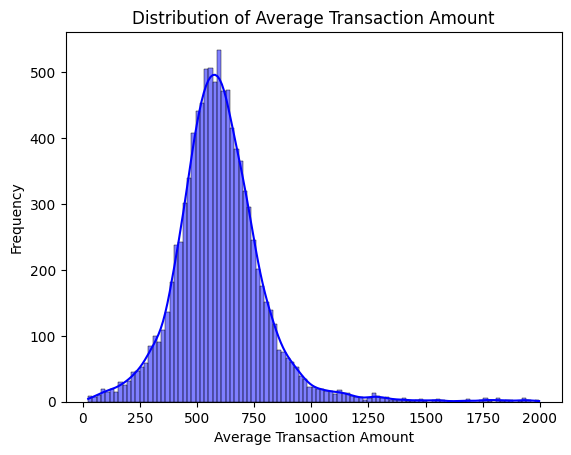

In [99]:
# Histogram to determine data distribution
sns.histplot(joint_data['Avg_Transaction_Amount'], kde=True, color='blue')  # KDE adds a density curve
plt.title('Distribution of Average Transaction Amount')
plt.xlabel('Average Transaction Amount')
plt.ylabel('Frequency')
plt.show()

In [100]:
# Recently purchased (tiering based on how recent their last purchase was)
def Recently_Purchased(x):
    if x<=14:
        return '2 weeks or less'
    if x>=15 and x<59:
        return '1-2 months ago'
    if x>=60:
        return '2+ months ago'
    else:
        return 'not applicable'

In [101]:
joint_data['Recently_Purchased'] = joint_data['most_recent_purchase_in_days'].apply(Recently_Purchased)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Avg_Transaction_Amount,Avg_Spending_Tier,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Gender_Categorical,Engage_Categorical,Recently_Purchased
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,584.913333,medium,2,75 days,75,118,inactive online,2,1,2+ months ago
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,675.702222,high,3,219 days,219,777,actively engaged,1,3,2+ months ago
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,242.478333,low,1,551 days,551,544,actively engaged,0,3,2+ months ago
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,393.734000,low,1,638 days,638,243,actively engaged,1,3,2+ months ago
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,646.856250,medium,2,364 days,364,494,actively engaged,1,3,2+ months ago
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,549.820000,medium,2,292 days,292,240,actively engaged,2,3,2+ months ago
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,487.358333,low,1,492 days,492,200,inactive online,1,1,2+ months ago
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,1167.710000,high,3,122 days,122,135,regularly checks online,1,2,2+ months ago


In [102]:
# Avg Transaction Time = how often do they make a transaction (in days)
joint_data['Avg_Transaction_Time'] = joint_data['Customer_Age_in_days']/joint_data['transaction_id']
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Avg_Spending_Tier,Avg_Spend_Categorical,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,Gender_Categorical,Engage_Categorical,Recently_Purchased,Avg_Transaction_Time
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,medium,2,75 days,75,118,inactive online,2,1,2+ months ago,19.666667
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,high,3,219 days,219,777,actively engaged,1,3,2+ months ago,86.333333
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,low,1,551 days,551,544,actively engaged,0,3,2+ months ago,90.666667
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,low,1,638 days,638,243,actively engaged,1,3,2+ months ago,12.150000
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,medium,2,364 days,364,494,actively engaged,1,3,2+ months ago,20.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,medium,2,292 days,292,240,actively engaged,2,3,2+ months ago,24.000000
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,low,1,492 days,492,200,inactive online,1,1,2+ months ago,16.666667
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,high,3,122 days,122,135,regularly checks online,1,2,2+ months ago,45.000000


## RFM (1 MONTH, 3 MONTHS, 6 MONTHS, 12 MONTHS)

RFM PREP

In [103]:
# Convert the 'date' column to datetime type
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [104]:
# set reference date
last_date = transactions['transaction_date'].max()

In [105]:
def calculate_rfm(data, end_date, days_label):
    rfm = data.groupby('customer_id').agg(
        recency = ('transaction_date', lambda x: (end_date - x.max()).days),
        frequency = ('transaction_id', 'count'),
        monetary = ('transaction_amount', 'sum')
    ).rename(columns={
        'recency': f'Recency_{days_label}',
        'frequency': f'Frequency_{days_label}',
        'monetary': f'Monetary_{days_label}'
    })
    return rfm

1 MONTH

In [106]:
# Define the time periods
days_30 = last_date - timedelta(days=30)

In [107]:
last_30_days = transactions[(transactions['transaction_date'] > days_30) & (transactions['transaction_date'] <= last_date)]

In [108]:
rfm_30 = calculate_rfm(last_30_days, last_date, '30')
rfm_30
# Conclusion: not enough data to conduct any modeling for rfm on last 30 days

,Recency_30,Frequency_30,Monetary_30
customer_id,,,
7,13,3,1018.16
48,19,1,439.69
59,24,8,4848.62
66,8,20,10795.72
90,1,19,11212.55
...,...,...,...
9869,28,1,408.71
9873,1,20,8405.83
9875,28,1,114.28


3 MONTHS

In [109]:
days_90 = last_date - timedelta(days=90)

In [110]:
last_90_days = transactions[(transactions['transaction_date'] > days_90) & (transactions['transaction_date'] <= last_date)]

In [111]:
rfm_90 = calculate_rfm(last_90_days, last_date, '90')
rfm_90

,Recency_90,Frequency_90,Monetary_90
customer_id,,,
1,80,1,146.86
7,13,3,1018.16
21,42,1,148.29
37,56,4,2136.82
38,65,2,299.14
...,...,...,...
9956,74,1,318.59
9973,50,6,4729.27
9976,49,2,456.78


In [112]:
# RFM Score Creation for 3 months
# Scoring Recency: Lower recency is better
rfm_90['R_Score'] = pd.qcut(rfm_90['Recency_90'], 4, labels=[4, 3, 2, 1])

# Scoring Frequency and Monetary: Higher values are better
rfm_90['F_Score'] = pd.qcut(rfm_90['Frequency_90'], 4, labels=[1, 2, 3, 4])
rfm_90['M_Score'] = pd.qcut(rfm_90['Monetary_90'], 4, labels=[1, 2, 3, 4])

# Combine scores to a single score
rfm_90['RFM_Score'] = rfm_90['R_Score'].astype(int) + rfm_90['F_Score'].astype(int) + rfm_90['M_Score'].astype(int)
rfm_90.head()

,Recency_90,Frequency_90,Monetary_90,R_Score,F_Score,M_Score,RFM_Score
customer_id,,,,,,,
1,80,1,146.86,1,1,1,3
7,13,3,1018.16,4,2,1,7
21,42,1,148.29,3,1,1,5
37,56,4,2136.82,2,2,2,6
38,65,2,299.14,2,1,1,4


In [113]:
rfm_90['90_day_avg'] = (rfm_90['Monetary_90'])/(rfm_90['Frequency_90'])

In [114]:
rfm_90 = pd.merge(rfm_90, joint_data[['join_date', 'age', 'number_of_site_visits', 'most_recent_purchase_in_days', 'Customer_Age_in_days','Customer_Engagement', 'LTV_Categorical', 'Avg_Spend_Categorical', 'Engage_Categorical', 'Gender_Categorical']], on='customer_id', how='left')
rfm_90.head()

,Recency_90,Frequency_90,Monetary_90,R_Score,F_Score,M_Score,RFM_Score,90_day_avg,join_date,age,number_of_site_visits,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,LTV_Categorical,Avg_Spend_Categorical,Engage_Categorical,Gender_Categorical
customer_id,,,,,,,,,,,,,,,,,,
1,80,1,146.86,1,1,1,3,146.860000,2023-11-20,56.0,10,75,118,inactive online,1,2,1,2
7,13,3,1018.16,4,2,1,7,339.386667,2023-12-11,NaN,64,2,170,regularly checks online,1,1,2,2
21,42,1,148.29,3,1,1,5,148.290000,2023-04-07,20.0,187,14,406,actively engaged,2,3,3,1
37,56,4,2136.82,2,2,2,6,534.205000,2023-06-17,54.0,34,39,310,regularly checks online,2,2,2,2
38,65,2,299.14,2,1,1,4,149.570000,2023-02-27,NaN,101,62,397,actively engaged,2,2,3,2


6 MONTHS

In [56]:
days_180 = last_date - timedelta(days=180)

In [57]:
last_180_days = transactions[(transactions['transaction_date'] > days_180) & (transactions['transaction_date'] <= last_date)]

In [58]:
rfm_180 = calculate_rfm(last_180_days, last_date, '180')
rfm_180.head()

,Recency_180,Frequency_180,Monetary_180
customer_id,,,
1,80,6,3509.48
7,13,5,1339.82
12,150,4,1587.62
15,162,2,1304.38
17,121,4,1314.81


In [60]:
# RFM Score Creation for 6 months
# Scoring Recency: Lower recency is better
rfm_180['R_Score'] = pd.qcut(rfm_180['Recency_180'], 4, labels=[4, 3, 2, 1])

# Scoring Frequency and Monetary: Higher values are better
rfm_180['F_Score'] = pd.qcut(rfm_180['Frequency_180'], 4, labels=[1, 2, 3, 4])
rfm_180['M_Score'] = pd.qcut(rfm_180['Monetary_180'], 4, labels=[1, 2, 3, 4])

# Combine scores to a single score
rfm_180['RFM_Score'] = rfm_180['R_Score'].astype(int) + rfm_180['F_Score'].astype(int) + rfm_180['M_Score'].astype(int)

In [61]:
rfm_180['180_day_avg'] = (rfm_180['Monetary_180'])/(rfm_180['Frequency_180'])

In [62]:
rfm_180 = pd.merge(rfm_180, joint_data[['most_recent_purchase_in_days', 'Customer_Age_in_days','Customer_Engagement', 'LTV_Categorical', 'Avg_Spend_Categorical', 'Engage_Categorical', 'Gender_Categorical']], on='customer_id', how='left')
rfm_180.head()

,Recency_180,Frequency_180,Monetary_180,R_Score,F_Score,M_Score,RFM_Score,180_day_avg,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,LTV_Categorical,Avg_Spend_Categorical,Engage_Categorical,Gender_Categorical
customer_id,,,,,,,,,,,,,,,
1,80,6,3509.48,3,2,3,8,584.913333,75,118,inactive online,1,2,1,2
7,13,5,1339.82,4,2,2,8,267.964000,2,170,regularly checks online,1,1,2,2
12,150,4,1587.62,1,2,2,5,396.905000,60,1059,actively engaged,2,3,3,1
15,162,2,1304.38,1,1,2,4,652.190000,152,644,actively engaged,3,2,3,2
17,121,4,1314.81,2,2,2,6,328.702500,116,66,inactive online,1,2,1,2


1 YEAR

In [64]:
days_365 = last_date - timedelta(days=365)

In [65]:
last_365_days = transactions[(transactions['transaction_date'] > days_365) & (transactions['transaction_date'] <= last_date)]

In [66]:
rfm_365 = calculate_rfm(last_365_days, last_date, '365')
rfm_365.head()

,Recency_365,Frequency_365,Monetary_365
customer_id,,,
1,80,6,3509.48
7,13,5,1339.82
8,305,7,4693.03
9,306,1,252.74
12,150,5,3221.32


In [67]:
# RFM Score Creation for 1 year
# Scoring Recency: Lower recency is better
rfm_365['R_Score'] = pd.qcut(rfm_365['Recency_365'], 4, labels=[4, 3, 2, 1])

# Scoring Frequency and Monetary: Higher values are better
rfm_365['F_Score'] = pd.qcut(rfm_365['Frequency_365'], 4, labels=[1, 2, 3, 4])
rfm_365['M_Score'] = pd.qcut(rfm_365['Monetary_365'], 4, labels=[1, 2, 3, 4])

# Combine scores to a single score
rfm_365['RFM_Score'] = rfm_365['R_Score'].astype(int) + rfm_365['F_Score'].astype(int) + rfm_365['M_Score'].astype(int)
rfm_365.head()

,Recency_365,Frequency_365,Monetary_365,R_Score,F_Score,M_Score,RFM_Score
customer_id,,,,,,,
1,80,6,3509.48,3,2,2,7
7,13,5,1339.82,4,2,1,7
8,305,7,4693.03,1,2,3,6
9,306,1,252.74,1,1,1,3
12,150,5,3221.32,3,2,2,7


In [68]:
rfm_365['1_yr_avg'] = (rfm_365['Monetary_365'])/(rfm_365['Frequency_365'])

In [69]:
rfm_365 = pd.merge(rfm_365, joint_data[['most_recent_purchase_in_days', 'Customer_Age_in_days','Customer_Engagement', 'LTV_Categorical', 'Avg_Spend_Categorical', 'Engage_Categorical', 'Gender_Categorical']], on='customer_id', how='left')
rfm_365.head()

,Recency_365,Frequency_365,Monetary_365,R_Score,F_Score,M_Score,RFM_Score,1_yr_avg,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Engagement,LTV_Categorical,Avg_Spend_Categorical,Engage_Categorical,Gender_Categorical
customer_id,,,,,,,,,,,,,,,
1,80,6,3509.48,3,2,2,7,584.913333,75,118,inactive online,1,2,1,2
7,13,5,1339.82,4,2,1,7,267.964000,2,170,regularly checks online,1,1,2,2
8,305,7,4693.03,1,2,3,6,670.432857,296,181,regularly checks online,3,3,2,1
9,306,1,252.74,1,1,1,3,252.740000,290,568,regularly checks online,3,1,2,2
12,150,5,3221.32,3,2,2,7,644.264000,60,1059,actively engaged,2,3,3,1


## MODELS

3 MONTH RFM - LOGISTIC REGRESSION

In [70]:
rfm_90.describe()

,Recency_90,Frequency_90,Monetary_90,RFM_Score,age_x,number_of_site_visits_x,most_recent_purchase_in_days_x,Customer_Age_in_days_x,Engage_Categorical_x,Gender_Categorical_x,90_day_avg,age_y,number_of_site_visits_y,most_recent_purchase_in_days_y,Customer_Age_in_days_y,Engage_Categorical_y,Gender_Categorical_y
count,1597.000000,1597.000000,1597.000000,1597.000000,1438.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1438.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000
mean,43.221039,7.522855,4518.181828,7.386349,43.444367,56.907326,32.838447,230.887289,1.763932,1.410770,601.504243,43.444367,56.907326,32.838447,230.887289,1.763932,1.410770
std,25.878366,6.892861,4334.761489,2.941644,14.954327,93.945814,24.258093,311.828313,0.729783,0.589451,296.713484,14.954327,93.945814,24.258093,311.828313,0.729783,0.589451
min,0.000000,1.000000,12.280000,3.000000,18.000000,1.000000,0.000000,0.000000,1.000000,0.000000,12.280000,18.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,20.000000,2.000000,1096.440000,5.000000,30.000000,4.000000,11.000000,27.000000,1.000000,1.000000,422.985000,30.000000,4.000000,11.000000,27.000000,1.000000,1.000000
50%,43.000000,5.000000,2824.670000,7.000000,44.000000,17.000000,28.000000,94.000000,2.000000,1.000000,573.112500,44.000000,17.000000,28.000000,94.000000,2.000000,1.000000
75%,65.000000,12.000000,6938.790000,10.000000,56.000000,65.000000,52.000000,310.000000,2.000000,2.000000,732.732857,56.000000,65.000000,52.000000,310.000000,2.000000,2.000000
max,89.000000,25.000000,22364.720000,12.000000,69.000000,676.000000,88.000000,1580.000000,3.000000,2.000000,1990.260000,69.000000,676.000000,88.000000,1580.000000,3.000000,2.000000


In [116]:
# 75th percentile or better for the RFM score is used for binary output because we are trying to predict the highest value customers
rfm_90['binary_output'] = rfm_90['RFM_Score'].apply(lambda x: 1 if x>=10 else 0)
rfm_90['binary_output'].value_counts()

binary_output
0    1115
1     482
Name: count, dtype: int64

In [160]:
# This model will predict whether over a 3 month period we will have a large amount of high value customers or not
X_90 = rfm_90[['90_day_avg', 'Customer_Age_in_days', 'LTV_Categorical', 'Avg_Spend_Categorical',
       'Engage_Categorical', 'Gender_Categorical']]
y_90 = rfm_90['binary_output']

In [161]:
# reserve 30% for testing
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X_90,y_90, test_size=0.3, random_state=42)

In [162]:
# build our pipeline that includes these transformations
numeric_columns_90 = ['90_day_avg', 'Customer_Age_in_days']
categorical_columns_90 = ['LTV_Categorical', 'Avg_Spend_Categorical', 'Engage_Categorical', 'Gender_Categorical']

In [163]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor_90 = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns_90),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns_90)
    ]
)

In [164]:
# test 3 models with cross validation to see which ones work best for this data
knn_90 = KNeighborsClassifier()
logreg_90 = LogisticRegression()
nb_90 = GaussianNB()

In [165]:
# cross validation to determine in general which model works best for the given problem
knn_scores_90 = cross_val_score(knn_90, X_train_90, y_train_90, scoring='f1', cv=5)
logreg_scores_90 = cross_val_score(logreg_90, X_train_90, y_train_90, scoring='f1', cv=5)
nb_scores_90 = cross_val_score(nb_90, X_train_90, y_train_90, scoring='f1', cv=5)
print(np.mean(knn_scores_90))
print(np.mean(logreg_scores_90))
print(np.mean(nb_scores_90))

# KNN ruled out because it has lowest score but Logreg will be put through the pipeline as it has
# more potential to be boosted

0.5891178186060075
0.6988513364672044
0.7073672843301324


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [201]:
# build our pipeline
pipeline_90 = Pipeline(steps=[
    ('preprocessor', preprocessor_90),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs'))])

In [202]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid_90 = {
  'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithms to use in the optimization problem
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Norm used in the penalization
    'classifier__max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

In [203]:
grid_search_90 = GridSearchCV(pipeline_90, param_grid_90, cv=5, verbose=1, scoring='f1')
grid_search_90.fit(X_train_90,y_train_90)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['90_day_avg',
                                                                          'Customer_Age_in_days']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['LTV_Categorical',
                                                                          'Avg_Spend_Categorical',
                                                                          'Engage_Categorical',
                                                                          'Gender_Categorical'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [100, 200, 300],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 'none'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'sag', 'saga']},
             scoring='f1', verbose=1)

In [204]:
final_classifier_90 = LogisticRegression(
    C=grid_search_90.best_params_['classifier__C'],
    solver=grid_search_90.best_params_['classifier__solver'],
    penalty=grid_search_90.best_params_['classifier__penalty'],
    max_iter=grid_search_90.best_params_['classifier__max_iter']
)

In [205]:
final_pipeline_90 = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor_90),
                              ('classifier',final_classifier_90)
                          ])

In [206]:
final_pipeline_90.fit(X_train_90,y_train_90)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['90_day_avg',
                                                   'Customer_Age_in_days']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['LTV_Categorical',
                                                   'Avg_Spend_Categorical',
                                                   'Engage_Categorical',
                                                   'Gender_Categorical'])])),
                ('classifier',
                 LogisticRegression(C=10, max_iter=200, penalty='l1',
                                    solver='saga'))])

In [207]:
pred_90 = final_pipeline_90.predict(X_test_90)

In [208]:
probs_90 = final_pipeline_90.predict_proba(X_test_90)

In [209]:
report_90 = classification_report(y_test_90, pred_90)
print(report_90)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       334
           1       0.71      0.77      0.74       146

    accuracy                           0.84       480
   macro avg       0.80      0.82      0.81       480
weighted avg       0.84      0.84      0.84       480



RandomForestRegressor - 3 MONTH RFM

In [137]:
# RandomForestRegressor Model
# Create a RandomForestRegressor object
model_90RFR = RandomForestRegressor(n_estimators=100, random_state=42)

In [166]:
# Splitting the data into training and testing sets
X_train_90RFR, X_test_90RFR, y_train_90RFR, y_test_90RFR = train_test_split(X_90, y_90, test_size=0.3, random_state=42)

In [167]:
# Fit the model to the training data
model_90RFR.fit(X_train_90RFR, y_train_90RFR)

RandomForestRegressor(random_state=42)

In [168]:
y_pred_90RFR= model_90RFR.predict(X_test_90RFR)
y_pred_90RFR

array([0.69, 0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.24,
       0.05, 0.  , 0.  , 0.  , 0.88, 0.08, 0.45, 0.43, 0.  , 0.  , 0.  ,
       0.  , 0.5 , 0.  , 0.11, 0.01, 0.96, 0.  , 0.  , 0.63, 0.  , 0.  ,
       0.85, 0.  , 0.11, 0.02, 0.  , 0.63, 0.88, 0.43, 0.86, 0.05, 0.34,
       0.  , 0.01, 0.  , 0.29, 0.48, 0.81, 0.04, 0.49, 0.04, 0.  , 0.8 ,
       0.16, 0.38, 0.  , 0.8 , 0.  , 0.55, 0.61, 0.15, 0.01, 0.  , 0.43,
       0.86, 0.05, 0.08, 0.9 , 0.96, 0.68, 0.  , 0.95, 0.01, 0.18, 0.68,
       0.26, 1.  , 0.57, 0.  , 0.  , 0.  , 0.26, 0.  , 0.01, 0.14, 0.44,
       0.  , 0.  , 0.  , 0.13, 0.2 , 0.01, 0.95, 0.  , 0.08, 0.37, 0.  ,
       0.45, 0.64, 0.  , 0.4 , 0.52, 0.65, 0.  , 0.98, 0.  , 0.12, 0.64,
       0.92, 0.67, 0.91, 0.26, 0.02, 0.76, 0.  , 0.1 , 0.79, 0.82, 0.  ,
       0.  , 0.91, 0.7 , 0.  , 0.03, 0.35, 0.97, 0.  , 0.19, 0.  , 0.02,
       0.01, 0.05, 0.95, 0.56, 0.03, 0.82, 0.21, 0.01, 0.  , 0.  , 0.42,
       0.  , 0.  , 0.22, 0.  , 0.26, 0.02, 0.  , 0.

In [169]:
# Convert predictions to binary by applying a threshold
threshold_90RFR = 0.5
y_pred_binary_90RFR = (y_pred_90RFR > threshold_90RFR).astype(int)

In [179]:
# 3 MONTH RFM - RandomForestRegressor Scores
print(classification_report(y_test_90RFR, y_pred_binary_90RFR))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       334
           1       0.71      0.71      0.71       146

    accuracy                           0.82       480
   macro avg       0.79      0.79      0.79       480
weighted avg       0.82      0.82      0.82       480



6 MONTHS

In [148]:
rfm_180.describe()

,Recency_180,Frequency_180,Monetary_180,RFM_Score,180_day_avg,most_recent_purchase_in_days,Customer_Age_in_days,Engage_Categorical,Gender_Categorical
count,2901.000000,2901.000000,2901.000000,2901.000000,2901.000000,2901.000000,2901.000000,2901.000000,2901.000000
mean,84.214409,7.973457,4801.346536,7.431231,605.569423,66.213375,310.610134,1.915891,1.417787
std,52.249582,6.874063,4357.921624,2.935604,288.929562,48.845926,362.280624,0.740335,0.587702
min,0.000000,1.000000,13.670000,3.000000,13.670000,0.000000,0.000000,1.000000,0.000000
25%,40.000000,2.000000,1250.310000,5.000000,429.587500,23.000000,48.000000,1.000000,1.000000
50%,80.000000,6.000000,3332.250000,7.000000,577.190000,58.000000,157.000000,2.000000,1.000000
75%,130.000000,12.000000,7497.400000,10.000000,725.120625,104.000000,448.000000,2.000000,2.000000
max,179.000000,25.000000,22364.720000,12.000000,1977.380000,177.000000,1580.000000,3.000000,2.000000


In [150]:
# 75th percentile or better for the RFM score is used for binary output because we are trying to predict the highest value customers
rfm_180['binary_output'] = rfm_180['RFM_Score'].apply(lambda x: 1 if x>=10 else 0)
rfm_180['binary_output'].value_counts()

binary_output
0    2016
1     885
Name: count, dtype: int64

In [159]:
# This model will predict whether over a 6 month period we will have a large amount of high value customers or not
X_180 = rfm_180[['180_day_avg', 'Customer_Age_in_days', 'LTV_Categorical', 'Avg_Spend_Categorical',
       'Engage_Categorical', 'Gender_Categorical']]
y_180 = rfm_180['binary_output']

In [171]:
# reserve 30% for testing
X_train_180, X_test_180, y_train_180, y_test_180 = train_test_split(X_180,y_180, test_size=0.3, random_state=42)

In [172]:
# build our pipeline that includes these transformations
numeric_columns_180 = ['180_day_avg', 'Customer_Age_in_days']
categorical_columns_180 = ['LTV_Categorical', 'Avg_Spend_Categorical', 'Engage_Categorical', 'Gender_Categorical']

In [173]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor_180 = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns_180),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns_180)
    ]
)

In [174]:
# test 3 models with cross validation to see which ones work best for this data
knn_180 = KNeighborsClassifier()
logreg_180 = LogisticRegression()
nb_180 = GaussianNB()

In [192]:
# cross validation to determine in general which model works best for the given problem
knn_scores_180 = cross_val_score(knn_180, X_train_180, y_train_180, scoring='f1', cv=5)
logreg_scores_180 = cross_val_score(logreg_180, X_train_180, y_train_180, scoring='f1', cv=5)
nb_scores_180 = cross_val_score(nb_180, X_train_180, y_train_180, scoring='f1', cv=5)

print(np.mean(knn_scores_180))
print(np.mean(logreg_scores_180))
print(np.mean(nb_scores_180))
# KNN ruled out because it has lowest score but Logreg will be put through the pipeline as it has
# more potential to be boosted

0.6044938660412246
0.6927368068846834
0.7164161386255516


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [210]:
# build our pipeline
pipeline_180 = Pipeline(steps=[
    ('preprocessor', preprocessor_180),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs'))])

In [211]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid_180 = {
  'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithms to use in the optimization problem
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Norm used in the penalization
    'classifier__max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

In [215]:
grid_search_180 = GridSearchCV(pipeline_180, param_grid_180, cv=5, verbose=1, scoring='f1')
grid_search_180.fit(X_train_180,y_train_180)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
975 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['180_day_avg',
                                                                          'Customer_Age_in_days']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['LTV_Categorical',
                                                                          'Avg_Spend_Categorical',
                                                                          'Engage_Categorical',
                                                                          'Gender_Categorical'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [100, 200, 300],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 'none'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'sag', 'saga']},
             scoring='f1', verbose=1)

In [216]:
final_classifier_180 = LogisticRegression(
    C=grid_search_180.best_params_['classifier__C'],
    solver=grid_search_180.best_params_['classifier__solver'],
    penalty=grid_search_180.best_params_['classifier__penalty'],
    max_iter=grid_search_180.best_params_['classifier__max_iter']
)

In [217]:
final_pipeline_180 = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor_180),
                              ('classifier',final_classifier_180)
                          ])

In [218]:
final_pipeline_180.fit(X_train_180,y_train_180)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['180_day_avg',
                                                   'Customer_Age_in_days']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['LTV_Categorical',
                                                   'Avg_Spend_Categorical',
                                                   'Engage_Categorical',
                                                   'Gender_Categorical'])])),
                ('classifier',
                 LogisticRegression(C=100, penalty='l1', solver='liblinear'))])

In [219]:
pred_180 = final_pipeline_180.predict(X_test_180)

In [220]:
probs_180 = final_pipeline_180.predict_proba(X_test_180)

In [222]:
report_180 = classification_report(y_test_180, pred_180)
print(report_180)

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       607
           1       0.70      0.72      0.71       264

    accuracy                           0.82       871
   macro avg       0.79      0.79      0.79       871
weighted avg       0.82      0.82      0.82       871



RandomForestRegressor - 6 MONTH RFM

In [158]:
# Create a RandomForestRegressor object
model_180RFR = RandomForestRegressor(n_estimators=100, random_state=42)

In [177]:
# Splitting the data into training and testing sets
X_train_180RFR, X_test_180RFR, y_train_180RFR, y_test_180RFR = train_test_split(X_180, y_180, test_size=0.3, random_state=42)

In [180]:
# Fit the model to the training data
model_180RFR.fit(X_train_180RFR, y_train_180RFR)

RandomForestRegressor(random_state=42)

In [181]:
y_pred_180RFR= model_180RFR.predict(X_test_180RFR)
y_pred_180RFR

array([0.  , 0.05, 0.  , 0.09, 0.22, 0.27, 0.08, 0.  , 0.38, 0.  , 0.02,
       0.  , 0.19, 0.01, 0.95, 0.34, 0.  , 0.85, 0.09, 0.71, 0.81, 0.09,
       0.91, 0.06, 0.11, 0.13, 0.56, 0.  , 0.02, 0.21, 0.12, 1.  , 0.  ,
       0.82, 0.  , 0.  , 0.25, 0.12, 0.23, 0.02, 0.57, 0.02, 0.37, 0.58,
       0.88, 0.  , 0.23, 0.1 , 0.37, 0.  , 0.77, 0.21, 0.09, 0.97, 0.91,
       0.  , 0.  , 0.91, 0.  , 0.16, 0.  , 0.4 , 0.25, 0.02, 0.58, 0.23,
       0.  , 0.  , 0.69, 0.98, 0.  , 0.72, 0.2 , 0.  , 0.03, 0.17, 0.49,
       0.93, 0.3 , 0.04, 0.73, 0.04, 0.11, 0.89, 0.58, 0.16, 0.3 , 0.  ,
       0.85, 0.  , 0.3 , 0.32, 0.66, 0.02, 0.  , 0.11, 0.21, 0.08, 0.07,
       0.  , 0.  , 0.08, 0.98, 1.  , 0.71, 0.97, 0.87, 0.7 , 0.06, 0.  ,
       0.91, 0.77, 0.  , 0.  , 0.61, 0.9 , 0.  , 0.05, 0.59, 0.08, 0.45,
       0.99, 0.  , 0.04, 0.79, 0.  , 0.01, 0.47, 0.53, 0.89, 0.38, 0.02,
       0.  , 0.82, 0.31, 0.16, 0.  , 0.94, 0.94, 0.32, 0.  , 0.13, 0.  ,
       0.72, 0.  , 0.47, 0.6 , 0.  , 0.1 , 0.83, 0.

In [182]:
# Convert predictions to binary by applying a threshold
threshold_180RFR = 0.5
y_pred_binary_180RFR = (y_pred_180RFR > threshold_180RFR).astype(int)

In [183]:
# 6 MONTH RFM - RandomForestRegressor Scores
print(classification_report(y_test_180RFR, y_pred_binary_180RFR))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       607
           1       0.72      0.69      0.70       264

    accuracy                           0.82       871
   macro avg       0.79      0.78      0.79       871
weighted avg       0.82      0.82      0.82       871



1 YEAR

In [184]:
rfm_365.describe()

,Recency_365,Frequency_365,Monetary_365,RFM_Score,1_yr_avg,most_recent_purchase_in_days,Customer_Age_in_days,Engage_Categorical,Gender_Categorical
count,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000
mean,162.291039,8.924663,5344.830426,7.404044,600.056621,132.727994,385.458763,2.062847,1.424266
std,104.928296,7.027966,4445.148673,2.903380,252.903350,98.512624,386.392789,0.739133,0.589092
min,0.000000,1.000000,11.680000,3.000000,11.680000,0.000000,0.000000,1.000000,0.000000
25%,68.000000,3.000000,1601.057500,5.000000,448.716181,46.000000,73.000000,2.000000,1.000000
50%,153.000000,7.000000,4095.695000,7.000000,580.578333,116.000000,245.000000,2.000000,1.000000
75%,250.250000,14.000000,8290.865000,10.000000,716.520821,210.000000,595.000000,3.000000,2.000000
max,364.000000,25.000000,22364.720000,12.000000,1990.290000,361.000000,1580.000000,3.000000,2.000000


In [185]:
# 75th percentile or better for the RFM score is used for binary output because we are trying to predict the highest value customers
rfm_365['binary_output'] = rfm_365['RFM_Score'].apply(lambda x: 1 if x>=10 else 0)

In [186]:
# This model will predict whether over a 6 month period we will have a large amount of high value customers or not
X_365 = rfm_365[['1_yr_avg', 'Customer_Age_in_days', 'LTV_Categorical', 'Avg_Spend_Categorical',
       'Engage_Categorical', 'Gender_Categorical']]
y_365 = rfm_365['binary_output']

In [187]:
# reserve 30% for testing
X_train_365, X_test_365, y_train_365, y_test_365 = train_test_split(X_365,y_365, test_size=0.3, random_state=42)

In [188]:
# build our pipeline that includes these transformations
numeric_columns_365 = ['1_yr_avg', 'Customer_Age_in_days']
categorical_columns_365 = ['LTV_Categorical', 'Avg_Spend_Categorical', 'Engage_Categorical', 'Gender_Categorical']

In [189]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor_365 = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns_365),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns_365)
    ]
)

In [190]:
# test 3 models with cross validation to see which ones work best for this data
knn_365 = KNeighborsClassifier()
logreg_365 = LogisticRegression()
nb_365 = GaussianNB()

In [234]:
# cross validation to determine in general which model works best for the given problem
knn_scores_365 = cross_val_score(knn_365, X_train_365, y_train_365, scoring='f1', cv=5)
logreg_scores_365 = cross_val_score(logreg_365, X_train_365, y_train_365, scoring='f1', cv=5)
nb_scores_365 = cross_val_score(nb_365, X_train_365, y_train_365, scoring='f1', cv=5)
print(np.mean(knn_scores_365))
print(np.mean(logreg_scores_365))
print(np.mean(nb_scores_365))
# KNN ruled out because it has lowest score but Logreg will be put through the pipeline as it has
# more potential to be boosted

0.49877449565379983
0.6761311077504125
0.7095916287744897


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [223]:
# build our pipeline
pipeline_365 = Pipeline(steps=[
    ('preprocessor', preprocessor_365),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs'))])

In [224]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid_365 = {
  'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithms to use in the optimization problem
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Norm used in the penalization
    'classifier__max_iter': [100, 200, 300]  # Maximum number of iterations taken for the solvers to converge
}

In [225]:
grid_search_365 = GridSearchCV(pipeline_365, param_grid_365, cv=5, verbose=1, scoring='f1')
grid_search_365.fit(X_train_365,y_train_365)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['1_yr_avg',
                                                                          'Customer_Age_in_days']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['LTV_Categorical',
                                                                          'Avg_Spend_Categorical',
                                                                          'Engage_Categorical',
                                                                          'Gender_Categorical'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [100, 200, 300],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 'none'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'sag', 'saga']},
             scoring='f1', verbose=1)

In [226]:
print(grid_search_365.best_params_)

{'classifier__C': 10, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


In [227]:
final_classifier_365 = LogisticRegression(
    C=grid_search_365.best_params_['classifier__C'],
    solver=grid_search_365.best_params_['classifier__solver'],
    penalty=grid_search_365.best_params_['classifier__penalty'],
    max_iter=grid_search_365.best_params_['classifier__max_iter']
)

In [228]:
final_pipeline_365 = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor_365),
                              ('classifier',final_classifier_365)
                          ])

In [229]:
final_pipeline_365.fit(X_train_365,y_train_365)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['1_yr_avg',
                                                   'Customer_Age_in_days']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['LTV_Categorical',
                                                   'Avg_Spend_Categorical',
                                                   'Engage_Categorical',
                                                   'Gender_Categorical'])])),
                ('classifier', LogisticRegression(C=10))])

In [230]:
pred_365 = final_pipeline_365.predict(X_test_365)

In [231]:
probs_365 = final_pipeline_365.predict_proba(X_test_365)

In [232]:
report_365 = classification_report(y_test_365, pred_365)
print(report_365)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1054
           1       0.74      0.75      0.75       460

    accuracy                           0.84      1514
   macro avg       0.82      0.82      0.82      1514
weighted avg       0.85      0.84      0.85      1514



RandomForestRegressor - 12 MONTH RFM

In [193]:
# Create a RandomForestRegressor object
model_365RFR = RandomForestRegressor(n_estimators=100, random_state=42)

In [194]:
# Splitting the data into training and testing sets
X_train_365RFR, X_test_365RFR, y_train_365RFR, y_test_365RFR = train_test_split(X_365, y_365, test_size=0.3, random_state=42)

In [195]:
# Fit the model to the training data
model_365RFR.fit(X_train_365RFR, y_train_365RFR)

RandomForestRegressor(random_state=42)

In [198]:
y_pred_365RFR= model_365RFR.predict(X_test_365RFR)
y_pred_365RFR

array([0.85, 0.93, 0.06, ..., 0.  , 0.52, 0.  ])

In [197]:
# Convert predictions to binary by applying a threshold
threshold_365RFR = 0.5
y_pred_binary_365RFR = (y_pred_365RFR > threshold_365RFR).astype(int)

In [200]:
# 1 YEAR RFM - RandomForestRegressor Scores
print(classification_report(y_test_365RFR, y_pred_binary_365RFR))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1054
           1       0.73      0.70      0.72       460

    accuracy                           0.83      1514
   macro avg       0.80      0.80      0.80      1514
weighted avg       0.83      0.83      0.83      1514

